# 从零实现RNN

## 导入包

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 独热编码
在train_iter中，每个词元都表示为一个数字索引， 将这些索引直接输入神经网络可能会使学习变得困难。 我们通常将每个词元表示为更具表现力的特征向量。 最简单的表示称为独热编码（one-hot encoding）。

In [2]:
# 初始化迭代器和词表
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# 将下标 0 和 2 转化为对应的 ont-hot 向量
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

输入的小批量数据形状为（batch_size, num_steps）

In [3]:
X = torch.arange(10).reshape((2, 5))
print(X)
print(X.T)
# 转置为（num_steps, batch_size），训练时同一时间步在同一列表中
F.one_hot(X.T, 28).shape

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]])


torch.Size([5, 2, 28])

## 初始化循环神经网络模型
![RNN](./assets/rnn.png)
$h_t = \tanh (W_{hh}h_{t-1}+W_{xh}x_{t-1} + b_h)$
$o_t = \tanh(W_{oh}+b_o)$

In [4]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    # 获取标准差为0.01的随机初始参数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    W_ho = normal((num_hiddens, num_outputs))
    # 输出层参数
    b_h = torch.zeros(num_hiddens, device=device)
    b_o = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_ho, b_o]
    for param in params:
        param.requires_grad_(True)
    return params


# 初始化0时刻的隐藏状态
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)


# 计算小批量输入各个时间步的隐藏状态和输出
def rnn(inputs, hidden_state, params):
    # inputs: [num_steps, batch_size, num_inputs]
    # hidden_state: [1, batch_size, num_hiddens]
    W_xh, W_hh, b_h, W_ho, b_o = params
    H, = hidden_state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(H, W_hh)
                       + torch.mm(X, W_xh)
                       + b_h)
        O = torch.mm(H, W_ho) + b_o
        outputs.append(O)
    outputs = torch.cat(outputs, dim=0)  # [num_steps * batch_size, num_inputs]
    return outputs, (H,)


# 创建一个类包装以上函数
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state = init_state
        self.forward_fn = forward_fn

    def __call__(self, X, hidden_state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, hidden_state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [5]:
# 检查输出
def check():
    num_hiddens = 512
    net = RNNModelScratch(len(vocab),
                          num_hiddens,
                          d2l.try_gpu(),
                          get_params,
                          init_rnn_state,
                          rnn)
    hidden_state = net.begin_state(batch_size=2,
                                   device=d2l.try_gpu())
    Y, hidden_state = net(X, hidden_state)
    print(Y.shape)  # [num_steps * batch_size, vocab_size]
    print(len(hidden_state))
    print(hidden_state[0].shape)  # [batch_size, num_hiddens]
check()

torch.Size([10, 28])
1
torch.Size([2, 512])


## 预测prefix之后的新字符

In [6]:
def predict_ch8(prefix, num_predict, net, vocab, device):
    hidden_state = net.begin_state(batch_size=1, device=device)
    tokens = [torch.tensor(vocab[c], device=device).reshape(1, 1) for c in prefix]
    for token in tokens:
        y, hidden_state = net(token, hidden_state)
    prediction = tokens
    prediction.append(y.argmax(dim=1).reshape(1, 1))
    for _ in range(num_predict-1):
        y, hidden_state = net(prediction[-1], hidden_state)
        prediction.append(y.argmax(dim=1).reshape(1, 1))
    prediction = [vocab.idx_to_token[i] for i in prediction]
    print("".join(prediction))

net = RNNModelScratch(len(vocab),
                      512,
                      d2l.try_gpu(),
                      get_params,
                      init_rnn_state,
                      rnn)
predict_ch8("time machine ", 10, net, vocab, d2l.try_gpu())


time machine c<unk>c<unk>c<unk>c<unk>c<unk>


## 梯度裁剪
$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$

In [7]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = math.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 一次epoch的训练

In [8]:
def train_epoch_ch8(net, train_iter, loss_fn, optimizer, device, use_random_iter):
    hidden_state = None
    timer = d2l.Timer()
    metric = d2l.Accumulator(2)
    net.to(device)
    for x, y in train_iter:
        # x: [batch_size, num_steps]
        # y: [batch_size, num_steps]

        # 初始化隐藏状态
        if hidden_state is None or use_random_iter:
            hidden_state = net.begin_state(batch_size=x.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(hidden_state, tuple):
                hidden_state.detach_()
            else:
                for s in hidden_state:
                    s.detach_()

        # 预测与调整
        y = y.T.reshape(-1)  # [num_steps * batch_size]
        x, y = x.to(device), y.to(device)
        y_hat, hidden_state = net(x, hidden_state)
        loss = loss_fn(y_hat, y.long()).mean()
        if isinstance(optimizer, torch.optim.Optimizer):
            optimizer.zero_grad()
            loss.backward()
            grad_clipping(net, 1)
            optimizer.step()
        else:
            loss.backward()
            grad_clipping(net, 1)
            optimizer(batch_size=1)  # 已经使用了mean，batch_size 设为1
        metric.add(loss * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


## 整体的训练

In [15]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss_fn = nn.CrossEntropyLoss()
    if isinstance(net, nn.Module):
        optimizer = torch.optim.SGD(net.parameters(), lr)
    else:
        optimizer = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss_fn, optimizer,
                                     device, use_random_iter)
        animator.add(epoch + 1, [ppl])
        if epoch % 10 == 0:
            print(predict('time traveller'))
    print(f"perplexity: {ppl:.1f}, speed: {speed:.1f} token(s)/sec, device: {str(device)}'")
    print(predict('time traveller'))
    print(predict('traveller'))
    print(predict('time machine'))

perplexity: 7.3, speed: 6457.8 token(s)/sec, device: cpu'
time traveller and the t
None
traveller and the t
None
time machine simension
None


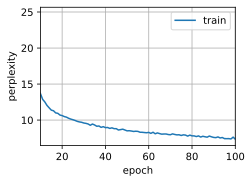

In [129]:
num_epochs = 100
lr = 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device=d2l.try_gpu())

In [130]:
predict_ch8('to', 50, net, vocab, d2l.try_gpu())

tore the this the this the this the this the this th


## torch实现的RNN

In [16]:
class RNNModel(nn.Module):
    def __init__(self, num_hiddens, vocab_size):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.vocab_size = vocab_size
        self.rnn = nn.RNN(vocab_size, num_hiddens)
        self.linear = nn.Linear(num_hiddens, vocab_size)

    def forward(self, inputs, hidden_state):
        # inputs: [batch_size, num_steps]
        # hidden_state: [1, batch_size, num_hiddens]

        # x: [num_steps, batch_size, num_inputs]
        x = F.one_hot(inputs.T, self.vocab_size).type(torch.float32)
        # y: [num_steps, batch_size, num_hiddens]
        # hidden_state: [num_layers, batch_size, num_hiddens]
        y, hidden_state = self.rnn(x, hidden_state)
        y = y.reshape(-1, self.num_hiddens)
        y = self.linear(y)
        # y: [num_steps * batch_size, num_inputs]
        return y, hidden_state

    def begin_state(self, batch_size, device):
        return torch.zeros((1, batch_size, self.num_hiddens)).to(device)


In [17]:
model = RNNModel(num_hiddens=512, vocab_size=len(vocab))

perplexity: 1.0, speed: 11278.7 token(s)/sec, device: cpu'
time traveller for so it will be convenient to speak of himwas e
None
travelleryou can show black is white by argument said filby
None
time machine by h g wellsithe time traveller for so it will be
None


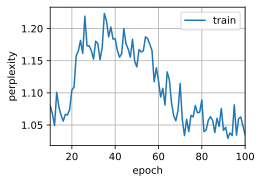

In [24]:
lr = 1
num_epochs = 100
device = d2l.try_gpu()
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [23]:
predict_ch8('t', 50, model, vocab, d2l.try_gpu())

the german scholars have improved greek so muchthen
